# Week 4: Lasso

The purpose of this week's exercises is to get our hands dirty using tools for high-dimensional estimation. We will here focus on the Lasso. However, most if not all exercises below can be done for the Ridge estimator, Dantzig selector, and the Elastic Net. (Do it!) We will use the "housing.csv" dataset, which contains data on house prices and more across districts in California. 

(The dataset is a slightly modified version of one initially featured in the paper "Sparse spatial autoregressions" by Pace and Barry in Statistics & Probability Letters 33.3 (1997), pp. 291-297. The data derive from the 1990 census, so it will sadly not help you predict current house prices)

We first read the data into Python and explore the dataset to begin with.

In [1]:
# Read data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from scipy.stats import norm
housing = pd.read_csv("housing.csv")
print("The number of rows and columns are {} and also called shape of the matrix".format(housing.shape)) # data dimensions
print("Columns names are: {}".format(housing.columns.to_list()))

The number of rows and columns are (20640, 10) and also called shape of the matrix
Columns names are: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']


In [2]:
print(housing.head()) # first observations

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  


In [3]:
print(housing.tail()) # last observations

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
20635    -121.09     39.48                25.0       1665.0           374.0   
20636    -121.21     39.49                18.0        697.0           150.0   
20637    -121.22     39.43                17.0       2254.0           485.0   
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                16.0       2785.0           616.0   

       population  households  median_income  median_house_value  \
20635       845.0       330.0         1.5603             78100.0   
20636       356.0       114.0         2.5568             77100.0   
20637      1007.0       433.0         1.7000             92300.0   
20638       741.0       349.0         1.8672             84700.0   
20639      1387.0       530.0         2.3886             89400.0   

      ocean_proximity  
20635          INLAND  
20636          INLAND  
20637          INLAND  
20638          INLAN

In [4]:
print(housing.dtypes) # data types

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object


In [5]:
housing.isnull().sum() # check for missing values

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

Some observations are missing a bedroom count. We here drop those. (An alternative approach is to impute the mean or median value and use all observations. Do it!)

In [6]:
#Change missing values in total_bedrooms to the mean of the column
housing['total_bedrooms'].fillna(housing['total_bedrooms'].mean(), inplace=True)
print(housing.isnull().sum()) # check for missing values again

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64


/var/folders/yb/2nwpczt56kvbrmb8klk29wfw0000gn/T/ipykernel_31821/3317872107.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  housing['total_bedrooms'].fillna(housing['total_bedrooms'].mean(), inplace=True)


We will model house prices (median_house_value) using a linear (in the parameters) model of the remaining basic regressors minus "ocean_proximity". (The latter variable is likely a predictor of house prices. However, due to its categorical nature, we will exclude it for the purpose of this exercise. A better  approach is to convert this categorical variable into a collection of dummies.)

In [7]:
y = housing.median_house_value
X = housing.drop(["median_house_value","ocean_proximity"],axis=1)
Xnames = X.columns
print(X.head()) # first regressor observations

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  
0       322.0       126.0         8.3252  
1      2401.0      1138.0         8.3014  
2       496.0       177.0         7.2574  
3       558.0       219.0         5.6431  
4       565.0       259.0         3.8462  


# Exercises

### Question 1: Standardization
Standardize the candidate regressors to bring everything onto the same scale. 

*Note 1:* One way is to use the functions mean() and std() from numpy

In [8]:
def standardize(X):

    X_tilde = (X - X.mean()) / X.std()
    return X_tilde

X_tilde = standardize(X)
print(X_tilde.head()) # first standardized regressor observations

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0  -1.327803  1.052523            0.982119    -0.804800       -0.975204   
1  -1.322812  1.043159           -0.607004     2.045841        1.355055   
2  -1.332794  1.038478            1.856137    -0.535733       -0.829712   
3  -1.337785  1.038478            1.856137    -0.624199       -0.722382   
4  -1.337785  1.038478            1.856137    -0.462393       -0.615052   

   population  households  median_income  
0   -0.974405   -0.977009       2.344709  
1    0.861418    1.669921       2.332181  
2   -0.820757   -0.843616       1.782656  
3   -0.766010   -0.733764       0.932945  
4   -0.759828   -0.629142      -0.012881  


### Question 2: Penalty Grid
Construct a grid of 50 candidate penalty levels from 0.01 to 80000, and estimate the linear model for each of these penalty levels while saving the coefficient estimates.

*Note 1:* Use np.geomspace to create a log scaled grid of penalty levels. 

*Note 2:* Use sklearn.linear_model.Lasso to estimate using Lasso. This is already loaded in as Lasso. The syntax is Lasso(alpha=penalty_level).fit(x,y) to get a "container" of results from the estimation. Read more about the Lasso function here: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html.

In [18]:
# Create a grid of 50 candidates withp penalty level 0,01 to 80000 using numpy.geomspace
penalty_grid = np.geomspace(0.01, 80000, num=50)
print(penalty_grid)

coefs=[]
for lamb in penalty_grid:
    #Fit the model using Lasso from sklearn with penalty level lamb and fit_intercept=True and the standardized X_tilde and y
    fit = Lasso(alpha=lamb, fit_intercept=True).fit(X_tilde, y)
    coefs.append(fit.coef_) # Note how we extract the coefficients from fit and append them to coefs

[1.00000000e-02 1.38318219e-02 1.91319296e-02 2.64629443e-02
 3.66030732e-02 5.06287188e-02 7.00287420e-02 9.68625086e-02
 1.33978497e-01 1.85316670e-01 2.56326717e-01 3.54546549e-01
 4.90402471e-01 6.78315963e-01 9.38234557e-01 1.29774933e+00
 1.79502375e+00 2.48284488e+00 3.43422681e+00 4.75016136e+00
 6.57033858e+00 9.08797528e+00 1.25703255e+01 1.73870504e+01
 2.40494584e+01 3.32647824e+01 4.60112545e+01 6.36419477e+01
 8.80284084e+01 1.21759327e+02 1.68415332e+02 2.32949087e+02
 3.22211027e+02 4.45676554e+02 6.16451870e+02 8.52665247e+02
 1.17939138e+03 1.63131315e+03 2.25640329e+03 3.12101684e+03
 4.31693490e+03 5.97110746e+03 8.25912948e+03 1.14238808e+04
 1.58013084e+04 2.18560883e+04 3.02309521e+04 4.18149144e+04
 5.78376448e+04 8.00000000e+04]


### Question 3: Lasso Path

Plot the (standardized) coefficient estimates as a function of the penalty level, i.e.
create what is known as the Lasso path. 

*Note 1:* Don't worry about the vlines for now.

In [12]:
def plot_lasso_path(penalty_grid, coefs, legends, vlines: dict = None):
    """
    Plots the coefficients as a function of the penalty parameter for Lasso regression.

    Parameters:
    penalty_grid (array-like): The penalty parameter values.
    coefs (array-like): The estimated coefficients for each penalty value.
    legends (list): The labels for each coefficient estimate.
    vlines (dict, optional): A dictionary of vertical lines to add to the plot. The keys are the names of the lines and the values are the penalty values where the lines should be drawn.
    
    """
    # Initiate figure 
    fig, ax = plt.subplots()

    # Plot coefficients as a function of the penalty parameter
    for i in range(len(coefs[0])):
        ax.plot(penalty_grid, np.array(coefs)[:, i], label=legends[i])

    # Set log scale for the x-axis
    ax.set_xscale('log')

    # Add labels
    plt.xlabel('Penalty, $\lambda$')
    plt.ylabel(r'Estimates, $\widehat{\beta}_j(\lambda)$')
    plt.title('Lasso Path')

    # Add legends
    lgd=ax.legend(legends,loc=(1.04,0))
    
    # Add vertical lines
    if vlines is not None:
        for name, penalty in vlines.items():
            ax.axvline(x=penalty, linestyle='--', color='grey')
            plt.text(penalty,-80000,name,rotation=90)

    
    # Display plot
    plt.show()
    plt.close()


<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:23: SyntaxWarning: invalid escape sequence '\l'
/var/folders/yb/2nwpczt56kvbrmb8klk29wfw0000gn/T/ipykernel_31821/1485496832.py:23: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('Penalty, $\lambda$')


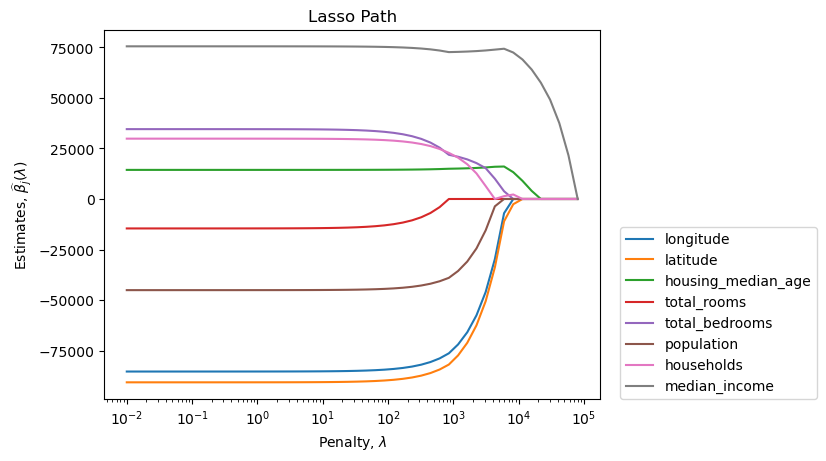

In [13]:
# Plot lasso path
plot_lasso_path(penalty_grid, coefs, Xnames)

You should get something that looks like this:

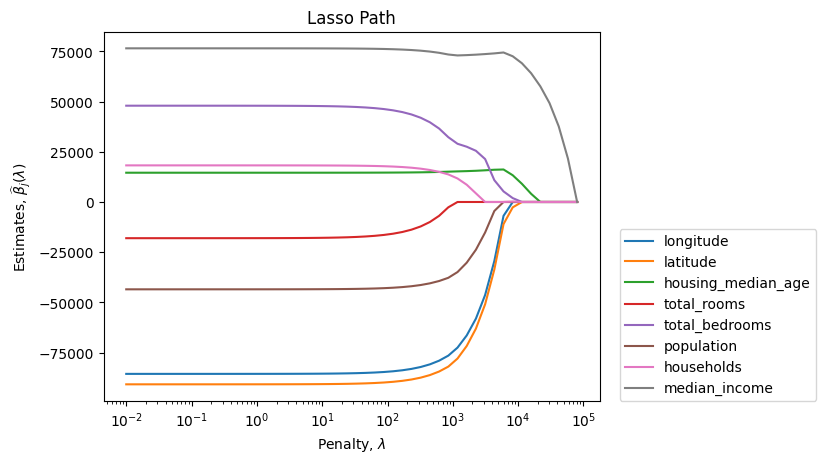

Hvad man ser i plottet:
For små λ (venstre side) har næsten alle variable ikke-nul koefficienter. Modellen minder om OLS.
Når λ øges, bevæger koefficienterne sig gradvist mod nul.
For store λ (højre side) bliver de fleste betas sat præcist til nul. Dette er den sparsitetseffekt, som Lasso skaber.

### Question 4: Cross Validation - penalty $\lambda$
Compute the penalty level and estimates implied by 5-fold cross-validation (5-CV). Which variables are selected by 5-CV? 

*Note 1:* Use sklearn.linear_model.LassoCV to estimate using Lasso with 5-CV. This is already loaded in as LassoCV.

*Note 2:* The argument "alphas" sets the grid of penalty levels that the 5-CV procedure will consider.

In [19]:
# Estimate the model using LassoCV
fit_CV = LassoCV(alphas=penalty_grid, cv=5, fit_intercept=True).fit(X_tilde, y)

# Investigate the penalty
penalty_CV = fit_CV.alpha_
print('Penalty_CV: ', round(penalty_CV,2))

# Investigate the coefficients
coeff_CV = fit_CV.coef_
print('Coefficients: ', np.round(coeff_CV))

# Investigate the selected variables
selected_variables = (coeff_CV!=0)
print('Selected variables: ', Xnames[selected_variables].to_list()) 

Penalty_CV:  0.01
Coefficients:  [-85394. -90734.  14404. -14574.  34574. -45110.  29865.  75559.]
Selected variables:  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']


You should get penalty_CV = 0.01

#### What does this error path suggest about the relationship between model sparsity and predictive power?
The model selects the smallest value of α, which results in all coefficients remaining non-zero. This indicates that regularisation does not improve predictive accuracy for this dataset. In other words, the signal is spread across many variables, and forcing sparsity through stronger penalisation removes useful information and increases prediction error. The optimal model therefore behaves almost like an OLS regression, capturing more of the underlying variation at the cost of less simplicity.

### Question 5.1: Visualize the estimates resulting from 5-CV

Consider the path of mean squared errors (MSE) for different penalty levels. Plot the mean MSE across folds as a function of the penalty level.

In [20]:
# Retrieve penalty and MSE
penalties_CV = fit_CV.alphas_
MSE_CV = np.mean(fit_CV.mse_path_, axis=1)

In [21]:
# Define a function that plots the MSE as a function of the penalty parameter
def plot_MSE_path(penalty_grid, MSE):
    """
    Plots the mean squared error (MSE) as a function of the penalty parameter.

    Parameters:
    penalty_grid (array-like): The penalty parameter values.
    MSE (array-like): The corresponding MSE values.

    """
    # Initiate figure 
    fig, ax = plt.subplots()

    # Plot MSE as a function of the penalty parameter
    ax.plot(penalty_grid, MSE, label='MSE', color='blue')

    # Set log scale for the x-axis
    ax.set_xscale('log')

    # Plot minimum MSE
    min_MSE_idx = np.argmin(MSE)
    min_MSE_penalty = penalty_grid[min_MSE_idx]
    ax.axvline(x=min_MSE_penalty, linestyle='--', color='grey')
    plt.text(min_MSE_penalty,1e10,"Minimum MSE",rotation=90)
    
    # Add labels
    plt.xlabel('Penalty, $\lambda$')
    plt.ylabel('Mean squared error')
    plt.title('Mean squared error')

    # Display plot
    plt.show()
    plt.close()

<>:27: SyntaxWarning: invalid escape sequence '\l'
<>:27: SyntaxWarning: invalid escape sequence '\l'
/var/folders/yb/2nwpczt56kvbrmb8klk29wfw0000gn/T/ipykernel_31821/3002466981.py:27: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('Penalty, $\lambda$')


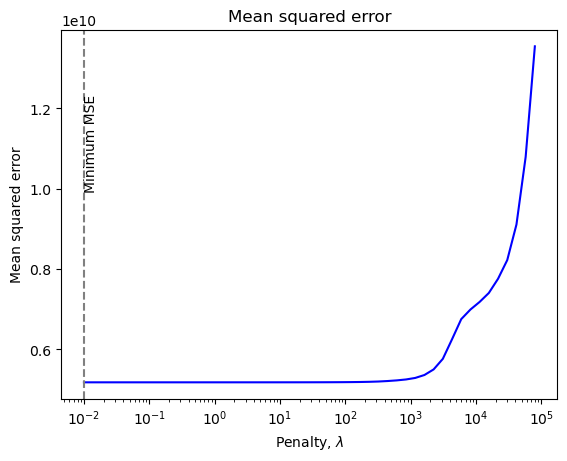

In [22]:
# Plot MSE as a function of the penalty parameter
plot_MSE_path(penalties_CV, MSE_CV)

#### What does this error path suggest about the relationship between model sparsity and predictive power? 
This error path shows that the mean squared error remains nearly constant for small penalty values and increases sharply as λ grows. The minimum MSE is reached at the lowest λ in the grid, meaning that stronger regularisation consistently worsens predictive accuracy. This suggests that the model benefits from including many active variables and that sparsity reduces performance. In this dataset, the best predictive power is obtained when the model is only weakly penalised, behaving almost like an unregularised OLS regression.

### How is the penalty chosen when using CV?
When using cross-validation (CV) in LassoCV, the penalty parameter λ (or equivalently α) is chosen by minimising the average prediction error across folds.

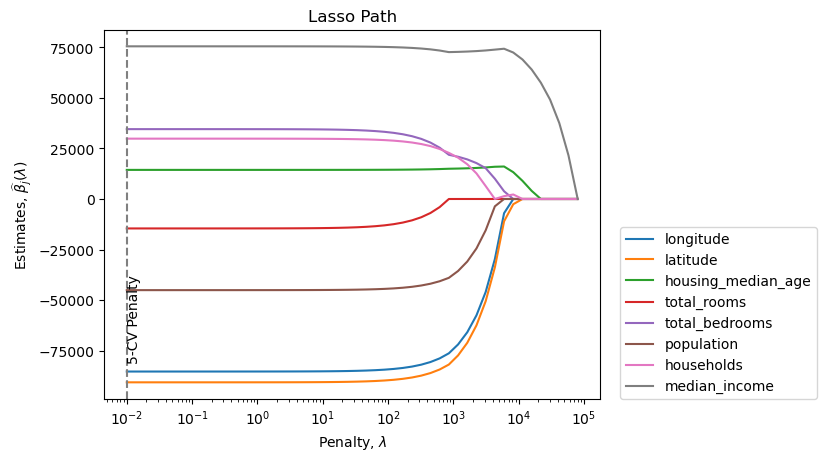

In [ ]:
#Visualize the estimates resulting from 5-CV by adding a vertical line to your Lasso path at the corresponding penalty level. Use vlines in plot_lasso_path to do this. How can you see which variables are selected by 5-CV?
# Plot lasso path
plot_lasso_path(penalty_grid, coefs, Xnames, vlines={'5-CV Penalty': penalty_CV})
#All variables with non-zero coefficients at this penalty level are selected by 5-CV

### Question 6: BRT penalty
Compute the (feasible) Bickel-Ritov-Tsybakov (BRT) penalty level, the resulting Lasso estimates, and visualize them in your path. Compare the BRT results to the CV
ones. 

*Note 1:* scipy.stats.norm.ppf gives you the inverse of the normal CDF. scipy.stats.norm is already imported as norm.

*Note 2:* Use a significance level of 5%, and set c=1.1.

*Note 3:* Remember that python defines the LASSO slightly differently than we do. In particular, the penalty level is 1/2 of what we define it as.

*Note 4:* The max term in the BRT penalty is equal to 1 when data is standardized.

In [76]:
# BRT penalty
n,p = X.shape
sigma = np.std(y)
c = 1.1
alpha = 0.05
q = norm.ppf(1 - alpha / (2 * p))
penalty_BRT = (c * sigma / np.sqrt(n)) * q #the penalty is divided by 2 compared to the lecture note since sklearn defines the penalty as 1/n * alpha * ||beta||_1
print('Penalty_BRT: ', round(penalty_BRT,2))

# Implied estimates and selection
fit_BRT = Lasso(alpha=penalty_BRT).fit(X_tilde,y)
coeff_BRT = fit_BRT.coef_
print('Coefficients: ', np.round(coeff_BRT))

# Selected variables
selected_variables_BRT = coeff_BRT != 0
selected_vars_list = np.array(Xnames)[selected_variables_BRT].tolist()
print("Selected variables:", selected_vars_list)

Penalty_BRT:  2415.87
Coefficients:  [-55455. -60334.  15414.     -0.  17310. -22824.  11511.  73256.]
Selected variables: ['longitude', 'latitude', 'housing_median_age', 'total_bedrooms', 'population', 'households', 'median_income']


You should get penalty_BRT = 2428.92

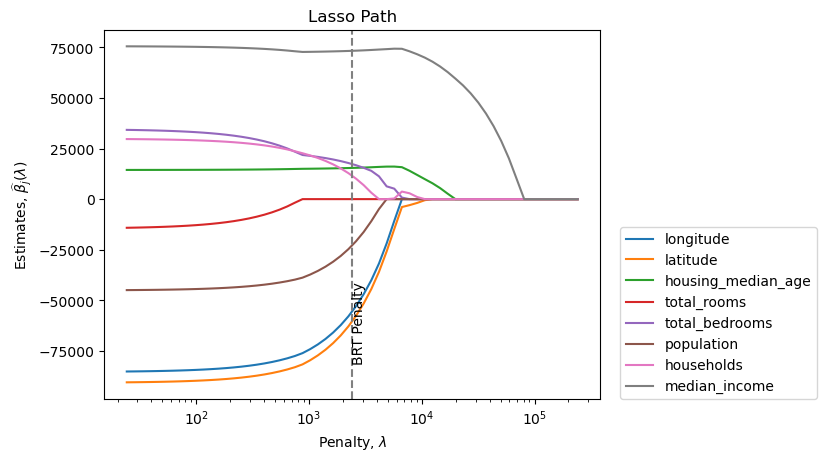

In [ ]:
#Print Lasso path with BRT penalty level
low = max(penalty_BRT / 100, 1e-12)   # guard against zero
high = penalty_BRT * 100
penalty_grid = np.geomspace(low, high, num=60)

coefs_matrix = np.empty((len(penalty_grid), p))
for k, lam in enumerate(penalty_grid):
    m = Lasso(alpha=float(lam), fit_intercept=True, max_iter=10000)
    m.fit(X_tilde, y)
    coefs_matrix[k, :] = m.coef_

# --- Plot with your function ---
plot_lasso_path(
    penalty_grid,
    coefs_matrix,            # shape (L, p)
    list(Xnames),            # legends
    vlines={'BRT Penalty': float(penalty_BRT)}
)

Figuren viser at total_rooms coefficienten bliver 0 "før" BRT penalty level. I modellen er den derfor sat til 0, hvilket også sås af printen af koefficienterne

### Question 7: BCCH penalty
 Compute the Belloni-Chen-Chernozhukov-Hansen (BCCH) pilot and updated penalty levels, the resulting Lasso estimates, and add them to your path. Compare
the BCCH penalty and estimates to both the CV and BRT ones.

*Note 1:* Use a significance level of 5%, and set c=1.1.

In [81]:
# BCCH pilot penalty
n,p = X.shape
c = 1.1
alpha = 0.05
yXscale = (np.max((X_tilde.T ** 2) @ ((y-np.mean(y)) ** 2) / n)) ** 0.5
penalty_pilot = c / np.sqrt(n) * norm.ppf(1-alpha/(2*p)) * yXscale # Note: Have divided by 2 due to Python definition of Lasso
print('Penalty_pilot: ', round(penalty_pilot, 2))

# Pilot estimates
#Create predicted value using Lasso 
pred = Lasso(alpha=penalty_pilot).fit(X_tilde,y).predict(X_tilde)

eps = y - pred 
epsXscale = (np.max((X_tilde.T ** 2) @ (eps ** 2) / n)) ** 0.5
penalty_BCCH = c*norm.ppf(1-alpha/(2*p))*epsXscale/np.sqrt(n)
print('Penalty BCCH: ', round(penalty_BCCH, 2))

Penalty_pilot:  4231.6
Penalty BCCH:  1859.48


In [82]:
# Updated estimates
fit_BCCH = Lasso(alpha=penalty_BCCH).fit(X_tilde,y)
coeff_BCCH = fit_BCCH.coef_
print('Coefficients: ', np.round(coeff_BCCH))

# Selected variables
Xnames_list = list(Xnames)
selected_vars_BCCH = [Xnames_list[i] for i, sel in enumerate(coeff_BCCH) if sel]

print("Selected variables:", selected_vars_BCCH)

Coefficients:  [-62901. -68023.  15256.     -0.  18932. -28589.  15537.  73055.]
Selected variables: ['longitude', 'latitude', 'housing_median_age', 'total_bedrooms', 'population', 'households', 'median_income']


You should get penalty_pilot = 4254.89

You should get penalty_BCCH = 1866.45

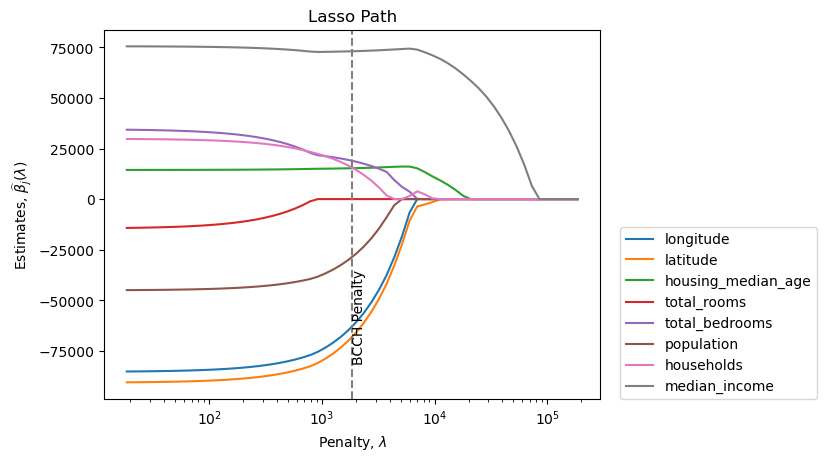

In [83]:
# Plot lasso path
low = max(penalty_BCCH / 100, 1e-12)   # guard against zero
high = penalty_BCCH * 100
penalty_grid = np.geomspace(low, high, num=60)

coefs_matrix = np.empty((len(penalty_grid), p))
for k, lam in enumerate(penalty_grid):
    m = Lasso(alpha=float(lam), fit_intercept=True, max_iter=10000)
    m.fit(Xn, y)
    coefs_matrix[k, :] = m.coef_

# --- Plot with your function ---
plot_lasso_path(
    penalty_grid,
    coefs_matrix,            # shape (L, p)
    list(Xnames),            # legends
    vlines={'BCCH Penalty': float(penalty_BCCH)}
)

### Question 8: Summary of estimates $\hat{\boldsymbol{\beta}}$
Gather the estimates in a table.


In [84]:
# Create pandas dataframe with variables in rows and CV, BRT and BCCH in columns
results_df = pd.DataFrame({
    'Variable': Xnames,
    'CV': coeff_CV,
    'BRT': coeff_BRT,
    'BCCH': coeff_BCCH
})
print(results_df)

             Variable            CV           BRT          BCCH
0           longitude -85393.819631 -55454.943954 -62901.316243
1            latitude -90733.979740 -60333.777415 -68022.942157
2  housing_median_age  14403.908130  15413.773658  15255.566820
3         total_rooms -14574.257386     -0.000000     -0.000000
4      total_bedrooms  34574.095724  17310.259426  18932.485121
5          population -45109.589122 -22823.857103 -28589.372385
6          households  29864.586125  11511.245385  15537.400441
7       median_income  75558.951294  73256.161611  73054.939672


You should get something that looks like this...

| | CV | BRT | BCCH | 
|-|-|-|-|
| longitude	| -85613  | -55772 |	-63318 |
| latitude	| -90815  | -60676 | -68463 |
| housing_median_age | 14580   | 15594 | 15437 |
| total_rooms | -18027       | 0 |0 |
| total_bedrooms |	47962   |	24936 | 26764 |
| population |	-43498  | -21994 | -27803 |
| households |	18236    |	3115 | 6979 |
| median_income	| 76536   | 73438 | 73236 |


### Question 9 (Optional): Repeat with more regressors
Redo the entire exercise after having added squares of the basic regressors. Note that creating the Lasso path may take a while and the algorithm may fail to converge at low penalty levels. If so, try to change the number of iterations by adjusting max_iter. [Hints: Create squares and use numpy.hstack to add them to the regressors in levels. You may also use sklearn.preprocessing.PolynomialFeatures to further add interaction terms.]

When it comes to the exact estimates, the resulting plot is here too crowded to be informative. But the plot still illustrates the expected order of the three penalty levels.

Compare your error path to the one you obtained in Question 4 - has the tradeoff between model sparsity and predictive power changed?